In [106]:
# Import all necessary libraries for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil              # For navigating files
from google.colab import drive # For mounting google drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
from imblearn import under_sampling, over_sampling

ImportError: cannot import name '_fit_context' from 'sklearn.base' (/usr/local/lib/python3.10/dist-packages/sklearn/base.py)

In [104]:
!pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# Data Import

In [2]:
# Mount the Google Drive to access the shot data data .zip files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Un-zip all the data files into Google Drive
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2007.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2008.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2009.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2010.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2011.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2012.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2013.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2014.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2015.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2016.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2017.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2018.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2019.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2020.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2021.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2022.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2023.zip

Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2007.zip
  inflating: shots_2007.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2008.zip
  inflating: shots_2008.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2009.zip
  inflating: shots_2009.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2010.zip
  inflating: shots_2010.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2011.zip
  inflating: shots_2011.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2012.zip
  inflating: shots_2012.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2013.zip
  inflating: shots_2013.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2014.zip
  inflating: shots_2014.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2015.zip
  inflating: shots_2015.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2016.zip
  inflating: shots_2016.csv          
Archive:  

In [4]:
# Define constants
SELECT_SEASONS = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
DATA_LOCATION = '/content'
CSV_BASE_NAME = 'shots_'

In [67]:
# Initialize list of dataframes
season_dfs = []

# Iterate through each season
for iSeason in SELECT_SEASONS:

  # Create full path to the current season's shot CSV data file
  full_path_to_csv = os.path.join(DATA_LOCATION, CSV_BASE_NAME + iSeason + '.csv')

  # Create dataframe for current season and append to the running list
  season_dfs.append(pd.read_csv(full_path_to_csv))

# Concatenate all dataframes into one
shot_df = pd.concat(season_dfs, ignore_index=True)

# Data Cleaning

In [ ]:
shot_df.describe()

In [ ]:
# Get all column names
cols = shot_df.columns
for iCol in range(cols.size):
  print(cols[iCol])

In [68]:
# Create copy of original dataframe in case needed
shot_df_copy = shot_df.copy()

In [69]:
# List out all the columns that we wish to analyze moving forward
cols_to_keep = ['arenaAdjustedShotDistance', 'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'awaySkatersOnIce', 'awayTeamCode', 'distanceFromLastEvent', 'event', 'homeSkatersOnIce', 'homeTeamCode', 'isHomeTeam', 'lastEventCategory', 'offWing', 'shootingTeamAverageTimeOnIce', 'shotAngleAdjusted', 'shotAngleReboundRoyalRoad', 'shotOnEmptyNet', 'shotRebound', 'shotRush', 'shotType', 'speedFromLastEvent', 'timeSinceFaceoff', 'timeSinceLastEvent']

In [70]:
# Remove all other, nonessential columns from the dataframe
for iCol in shot_df.columns:
  if iCol not in cols_to_keep:
    shot_df.drop(iCol, axis=1, inplace=True)

In [71]:
# Remove all shots from games that do not involve the CO Avalanche
index_non_avs = shot_df[(shot_df['awayTeamCode'] != 'COL') & (shot_df['homeTeamCode'] != 'COL')].index
shot_df.drop(index_non_avs, inplace=True)
shot_df.head(15)

,homeTeamCode,awayTeamCode,timeSinceLastEvent,event,shotAngleAdjusted,shotAngleReboundRoyalRoad,shotType,shotOnEmptyNet,shotRebound,shotRush,...,lastEventCategory,homeSkatersOnIce,awaySkatersOnIce,timeSinceFaceoff,shootingTeamAverageTimeOnIce,offWing,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,isHomeTeam,arenaAdjustedXCordABS
395,COL,DAL,54,SHOT,30.801446,0,SLAP,0,0,0,...,TAKE,5,5,114,23.6,0,58.0,30.0,1.0,39.0
396,COL,DAL,20,SHOT,38.453709,0,SLAP,0,0,0,...,SHOT,5,5,134,19.0,1,42.0,26.0,1.0,56.0
397,COL,DAL,8,SHOT,57.528808,0,BACK,0,0,0,...,FAC,5,5,8,8.0,0,14.0,12.0,1.0,81.0
398,COL,DAL,48,SHOT,41.423666,0,WRIST,0,0,0,...,BLOCK,5,5,67,74.4,1,44.0,29.0,0.0,56.0
399,COL,DAL,5,SHOT,70.559965,1,WRIST,0,0,0,...,SHOT,5,5,72,79.4,0,34.0,32.0,0.0,78.0
400,COL,DAL,36,SHOT,70.974394,0,WRIST,0,0,0,...,GIVE,5,5,178,24.8,0,28.0,26.0,0.0,80.0
401,COL,DAL,12,SHOT,41.185925,0,WRIST,0,0,0,...,SHOT,5,5,190,26.2,0,13.0,9.0,1.0,79.0
402,COL,DAL,11,SHOT,24.034288,0,SLAP,0,0,0,...,FAC,5,4,11,11.2,0,70.0,29.0,1.0,25.0
403,COL,DAL,13,SHOT,45.881404,0,WRIST,0,0,0,...,GIVE,5,4,31,23.5,0,45.0,32.0,0.0,58.0
404,COL,DAL,20,SHOT,47.726311,0,WRIST,0,0,0,...,TAKE,5,5,45,30.8,1,17.0,13.0,0.0,78.0


In [72]:
# Remove empty net shots from the dataframe, as skew shot goal results are skewed when no goalie is present
index_empty_net = shot_df[(shot_df['shotOnEmptyNet'] == 1)].index
shot_df.drop(index_empty_net, inplace=True)

In [73]:
# Create new feature for whether or not this is an Avs home game
shot_df['isHomeGame'] = np.where(shot_df['homeTeamCode'] == 'COL', 1, 0)

In [74]:
# Remove home game shots that were taken by team that was opposing the Avalanche
index_other_team_shots = shot_df[(shot_df['isHomeGame'] == True) & (shot_df['isHomeTeam'] < 0.5)].index
shot_df.drop(index_other_team_shots, inplace=True)

In [75]:
# Repeat the above removal for Avalanche away games
index_other_team_shots = shot_df[(shot_df['isHomeGame'] == False) & (shot_df['isHomeTeam'] > 0.5)].index
shot_df.drop(index_other_team_shots, inplace=True)

In [76]:
# Print out the resulting number of shots that the Avalanche have taken since 2007
shot_df.shape[0]

57817

In [81]:
# Check for indices corresponding to missing values in the dataframe
np.where(pd.isnull(shot_df))

(array([], dtype=int64), array([], dtype=int64))

In [78]:
# Fill the missing shot types with wrist shots, as they are the most common
shot_df['shotType'].fillna('WRIST', inplace=True)

In [79]:
# Verify the wrist shots were added for missing values
print(shot_df['shotType'].unique())

['SLAP' 'BACK' 'WRIST' 'TIP' 'WRAP' 'SNAP' 'DEFL']


In [80]:
shot_df.head(15)

,homeTeamCode,awayTeamCode,timeSinceLastEvent,event,shotAngleAdjusted,shotAngleReboundRoyalRoad,shotType,shotOnEmptyNet,shotRebound,shotRush,...,homeSkatersOnIce,awaySkatersOnIce,timeSinceFaceoff,shootingTeamAverageTimeOnIce,offWing,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,isHomeTeam,arenaAdjustedXCordABS,isHomeGame
395,COL,DAL,54,SHOT,30.801446,0,SLAP,0,0,0,...,5,5,114,23.6,0,58.0,30.0,1.0,39.0,1
396,COL,DAL,20,SHOT,38.453709,0,SLAP,0,0,0,...,5,5,134,19.0,1,42.0,26.0,1.0,56.0,1
397,COL,DAL,8,SHOT,57.528808,0,BACK,0,0,0,...,5,5,8,8.0,0,14.0,12.0,1.0,81.0,1
401,COL,DAL,12,SHOT,41.185925,0,WRIST,0,0,0,...,5,5,190,26.2,0,13.0,9.0,1.0,79.0,1
402,COL,DAL,11,SHOT,24.034288,0,SLAP,0,0,0,...,5,4,11,11.2,0,70.0,29.0,1.0,25.0,1
405,COL,DAL,27,MISS,8.914927,0,SLAP,0,0,0,...,5,5,72,31.4,0,51.0,8.0,1.0,39.0,1
406,COL,DAL,13,SHOT,19.746837,0,WRIST,0,0,0,...,5,5,130,33.2,0,40.0,14.0,1.0,51.0,1
408,COL,DAL,9,MISS,31.429566,0,SLAP,0,0,0,...,5,5,36,41.4,0,41.0,21.0,1.0,54.0,1
411,COL,DAL,18,SHOT,4.398705,0,WRIST,0,0,0,...,5,5,40,23.2,0,25.0,2.0,1.0,64.0,1
412,COL,DAL,1,SHOT,46.636577,1,WRIST,0,1,0,...,5,5,41,24.2,1,24.0,17.0,1.0,73.0,1


In [82]:
print(shot_df['lastEventCategory'].unique())

['TAKE' 'SHOT' 'FAC' 'HIT' 'GIVE' 'MISS' 'BLOCK' 'STOP' 'PENL' 'EISTR'
 'GOAL' 'CHL' 'PEND' 'DELPEN']


In [83]:
# Create the label column for whether or not the Avalanche shot resulted in a goal
shot_df['isGoal'] = np.where(shot_df['event'] == 'GOAL', 1, 0)

In [84]:
# Remove features that are no longer necessary
shot_df.drop('event', axis=1, inplace=True)
shot_df.drop('shotOnEmptyNet', axis=1, inplace=True)

In [85]:
# One-hot encode the shorthanded shots using the number of Avs and opposing players on the ice
shot_df['isShortSided'] = shot_df.apply(lambda x: 1 if ((x['isHomeGame'] == 1 and (x['homeSkatersOnIce'] < x['awaySkatersOnIce'])) or
                                                        (x['isHomeGame'] == 0 and (x['homeSkatersOnIce'] > x['awaySkatersOnIce']))) else 0, axis=1)

# Repeat for even strength matchups
shot_df['isEvenStrength'] = shot_df.apply(lambda x: 1 if (x['homeSkatersOnIce'] == x['awaySkatersOnIce']) else 0, axis=1)

# Repeat for power-plays with one less opposing skater than Avs skaters on the ice
shot_df['isPowerPlay'] = shot_df.apply(lambda x: 1 if ((x['isHomeGame'] == 1 and (x['homeSkatersOnIce'] == (x['awaySkatersOnIce'] + 1))) or
                                                       (x['isHomeGame'] == 0 and (x['homeSkatersOnIce'] == (x['awaySkatersOnIce'] - 1)))) else 0, axis=1)

# Repeat for power-plays with at least two less opposing skater than Avs skaters on the ice
shot_df['isExtraPowerPlay'] = shot_df.apply(lambda x: 1 if ((x['isHomeGame'] == 1 and (x['homeSkatersOnIce'] >= (x['awaySkatersOnIce'] + 2))) or
                                                            (x['isHomeGame'] == 0 and (x['homeSkatersOnIce'] <= (x['awaySkatersOnIce'] - 2)))) else 0, axis=1)

In [86]:
# Remove features that are no longer necessary
shot_df.drop('awaySkatersOnIce', axis=1, inplace=True)
shot_df.drop('homeSkatersOnIce', axis=1, inplace=True)
shot_df.drop('awayTeamCode', axis=1, inplace=True)
shot_df.drop('homeTeamCode', axis=1, inplace=True)
shot_df.drop('isHomeTeam', axis=1, inplace=True)

In [87]:
shot_df.head(15)

,timeSinceLastEvent,shotAngleAdjusted,shotAngleReboundRoyalRoad,shotType,shotRebound,shotRush,speedFromLastEvent,distanceFromLastEvent,lastEventCategory,timeSinceFaceoff,...,offWing,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,arenaAdjustedXCordABS,isHomeGame,isGoal,isShortSided,isEvenStrength,isPowerPlay,isExtraPowerPlay
395,54,30.801446,0,SLAP,0,0,0.893890,48.270074,TAKE,114,...,0,58.0,30.0,39.0,1,0,0,1,0,0
396,20,38.453709,0,SLAP,0,0,0.921954,18.439089,SHOT,134,...,1,42.0,26.0,56.0,1,0,0,1,0,0
397,8,57.528808,0,BACK,0,0,2.576941,20.615528,FAC,8,...,0,14.0,12.0,81.0,1,0,0,1,0,0
401,12,41.185925,0,WRIST,0,0,13.666667,164.000000,SHOT,190,...,0,13.0,9.0,79.0,1,0,0,1,0,0
402,11,24.034288,0,SLAP,0,0,4.636364,51.000000,FAC,11,...,0,70.0,29.0,25.0,1,0,0,0,1,0
405,27,8.914927,0,SLAP,0,0,1.673648,45.188494,SHOT,72,...,0,51.0,8.0,39.0,1,0,0,1,0,0
406,13,19.746837,0,WRIST,0,0,11.317108,147.122398,HIT,130,...,0,40.0,14.0,51.0,1,0,0,1,0,0
408,9,31.429566,0,SLAP,0,0,6.376074,57.384667,GIVE,36,...,0,41.0,21.0,54.0,1,0,0,1,0,0
411,18,4.398705,0,WRIST,0,0,6.530319,117.545736,MISS,40,...,0,25.0,2.0,64.0,1,0,0,1,0,0
412,1,46.636577,1,WRIST,1,0,21.931712,21.931712,SHOT,41,...,1,24.0,17.0,73.0,1,0,0,1,0,0


In [88]:
# One-hot encode the shot type and last event categorical features
shot_df_encoded = pd.get_dummies(shot_df, columns=['shotType', 'lastEventCategory'])

In [89]:
# Verify the one-hot encoding was successful
shot_df_encoded.head(15)

,timeSinceLastEvent,shotAngleAdjusted,shotAngleReboundRoyalRoad,shotRebound,shotRush,speedFromLastEvent,distanceFromLastEvent,timeSinceFaceoff,shootingTeamAverageTimeOnIce,offWing,...,lastEventCategory_FAC,lastEventCategory_GIVE,lastEventCategory_GOAL,lastEventCategory_HIT,lastEventCategory_MISS,lastEventCategory_PEND,lastEventCategory_PENL,lastEventCategory_SHOT,lastEventCategory_STOP,lastEventCategory_TAKE
395,54,30.801446,0,0,0,0.893890,48.270074,114,23.6,0,...,False,False,False,False,False,False,False,False,False,True
396,20,38.453709,0,0,0,0.921954,18.439089,134,19.0,1,...,False,False,False,False,False,False,False,True,False,False
397,8,57.528808,0,0,0,2.576941,20.615528,8,8.0,0,...,True,False,False,False,False,False,False,False,False,False
401,12,41.185925,0,0,0,13.666667,164.000000,190,26.2,0,...,False,False,False,False,False,False,False,True,False,False
402,11,24.034288,0,0,0,4.636364,51.000000,11,11.2,0,...,True,False,False,False,False,False,False,False,False,False
405,27,8.914927,0,0,0,1.673648,45.188494,72,31.4,0,...,False,False,False,False,False,False,False,True,False,False
406,13,19.746837,0,0,0,11.317108,147.122398,130,33.2,0,...,False,False,False,True,False,False,False,False,False,False
408,9,31.429566,0,0,0,6.376074,57.384667,36,41.4,0,...,False,True,False,False,False,False,False,False,False,False
411,18,4.398705,0,0,0,6.530319,117.545736,40,23.2,0,...,False,False,False,False,True,False,False,False,False,False
412,1,46.636577,1,1,0,21.931712,21.931712,41,24.2,1,...,False,False,False,False,False,False,False,True,False,False


# SMOTE to Handle Data Imbalance

In [100]:
# Get the Avalanche number of non-goals and goals across all seasons
shot_df_encoded['isGoal'].value_counts()

isGoal
0    53886
1     3931
Name: count, dtype: int64

# Train/Test Data Splitting

In [90]:
# Define goals as the labels to predict, then convert to numpy array
goal_labels = np.array(shot_df_encoded['isGoal'])

# Remove the labels from the dataframe
shot_df_label_removed = shot_df_encoded.drop('isGoal', axis = 1)

# Capture feature names
feature_list = list(shot_df_label_removed.columns)

# Convert dataframe for features to numpy array
shot_arr = np.array(shot_df_label_removed)

In [91]:
# Split the shot data into training and test data sets
train_shot_features, test_shot_features, train_goal_labels, test_goal_labels = train_test_split(shot_arr, goal_labels, test_size = 0.25, random_state = 55)

In [92]:
# Verify the split was successful
print(train_shot_features.shape)
print(test_shot_features.shape)
print(train_goal_labels.shape)
print(test_goal_labels.shape)

(43362, 39)
(14455, 39)
(43362,)
(14455,)


# Random Forest Classifier

In [93]:
# Create random forest model using 1000 decision trees
rand_forest = RandomForestClassifier(n_estimators = 1000, random_state = 55)

# Add random number column to gauge feature importance

# TO DO: look into sklearn.metrics -> Mutual information: helps with unbalanced datasets

  # helps with less common features, etc

  # scikitplot.estimators for feature importance plot

# Train the model on training data
rand_forest.fit(train_shot_features, train_goal_labels)

RandomForestClassifier(n_estimators=1000, random_state=55)

In [94]:
# Calculate importance of all shot features
feat_imp = list(rand_forest.feature_importances_)

# Create tuple that relates the importance rating with each feature name
feat_imp_tup = [(feat, imp) for feat, imp in zip(feature_list, feat_imp)]

# Sort the tuple from most important shot feature to least important
feat_imp_tup = sorted(feat_imp_tup, key = lambda x: x[1], reverse = True)

In [95]:
# Predict goals for the test set and output the accuracy metric
goal_predictions = rand_forest.predict(test_shot_features)
accuracy_metric = accuracy_score(test_goal_labels, goal_predictions)
print("Accuracy:", accuracy_metric)

Accuracy: 0.9318574887582152


In [96]:
# Create and display confusion matrix to see TP/FP/TN/FN counts
def display_confusion_matrix(test_labels, predictions):
  conf_mat = confusion_matrix(test_labels, predictions)
  conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['No Goal', 'Goal'])
  conf_disp.plot()
  plt.show()

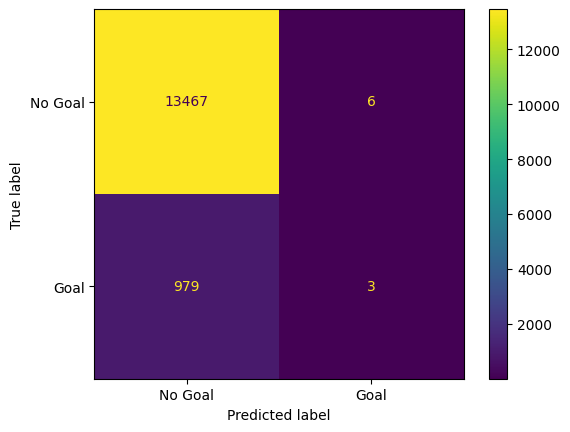

In [97]:
display_confusion_matrix(test_goal_labels, goal_predictions)

In [98]:
# Calculate and display the F1-score
f1_score(test_goal_labels, goal_predictions)

0.006054490413723511

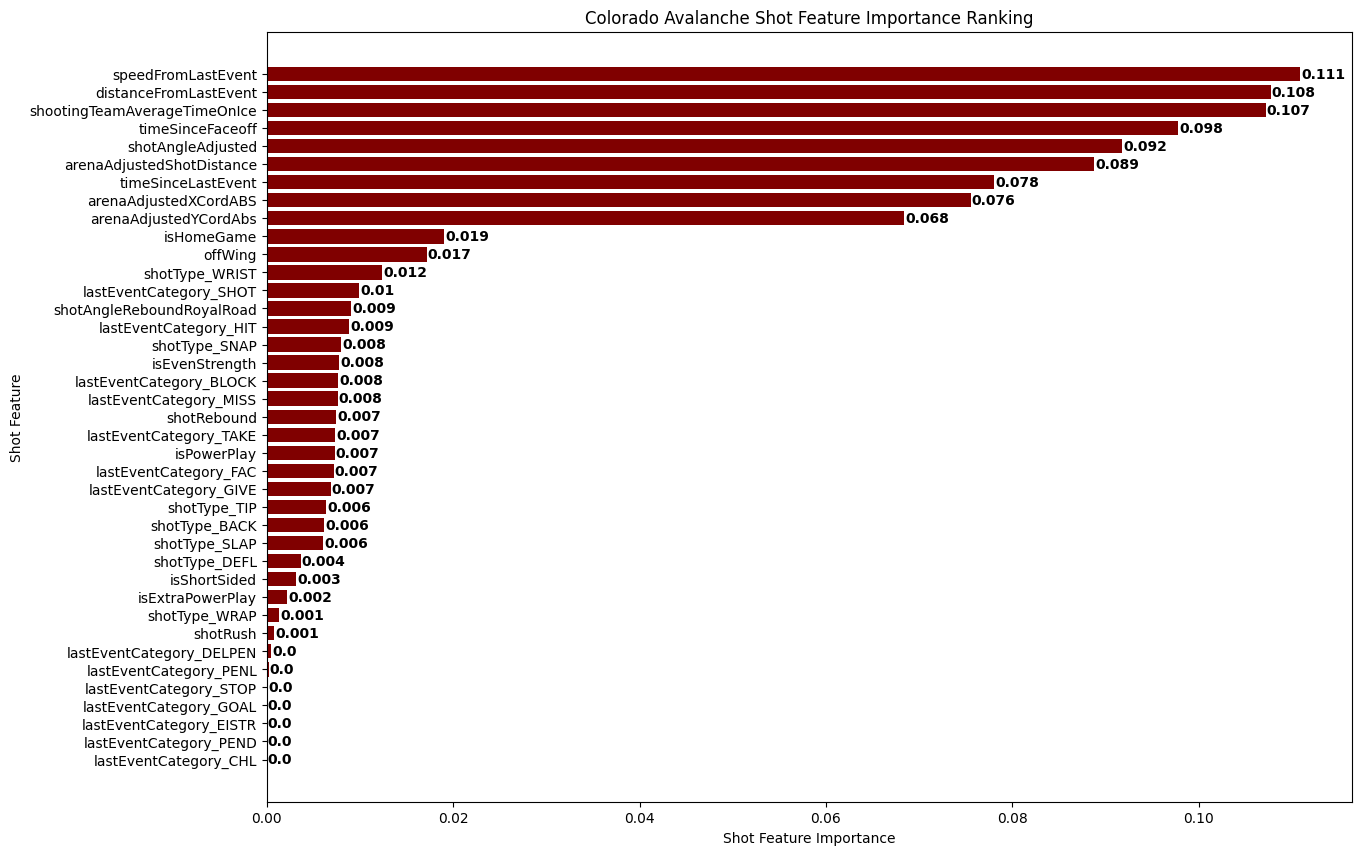

In [99]:
# Create barplot of the feature importances
fig, ax = plt.subplots(figsize = (14, 10))
ax.barh(list(zip(*feat_imp_tup))[0], list(zip(*feat_imp_tup))[1], color = 'maroon')
ax.invert_yaxis()
for patch in ax.patches:
    plt.text(patch.get_width() + 0.0001,
             patch.get_y() + 0.63,
             str(round((patch.get_width()), 3)),
             fontsize = 10,
             fontweight = 'bold',
             color = 'black')
plt.xlabel("Shot Feature Importance")
plt.ylabel("Shot Feature")
plt.title("Colorado Avalanche Shot Feature Importance Ranking")
plt.show()

In [ ]:
  # TO TRY: column of random numbers and that can be used as cutoff point

  # autoML (pyCaret) -> give target as yes/no goal, will tell which algorithm works best for classification

# Using PyCaret AutoML to Compare Model Types

In [ ]:
# Import necessary library
#!pip install pycaret
#import pycaret.classification as pycc